# Load libraries

In [47]:
from skimage.io import imread
import matplotlib.pyplot as plt
import numpy as np, pandas as pd
from skimage.color import rgb2gray
from skimage.filters import sobel, scharr, apply_hysteresis_threshold, gaussian
from skimage.feature import canny
from skimage.measure import regionprops,regionprops_table
from skimage.morphology import binary_opening, disk, binary_closing, binary_dilation, binary_erosion
from skimage.draw import rectangle_perimeter
from scipy.ndimage import label as scilabel
import cv2
import matplotlib; matplotlib.rcParams['figure.dpi']=300

# Read image and plot

In [48]:
img=imread("train/imgs/10.png")

(-0.5, 255.5, 255.5, -0.5)

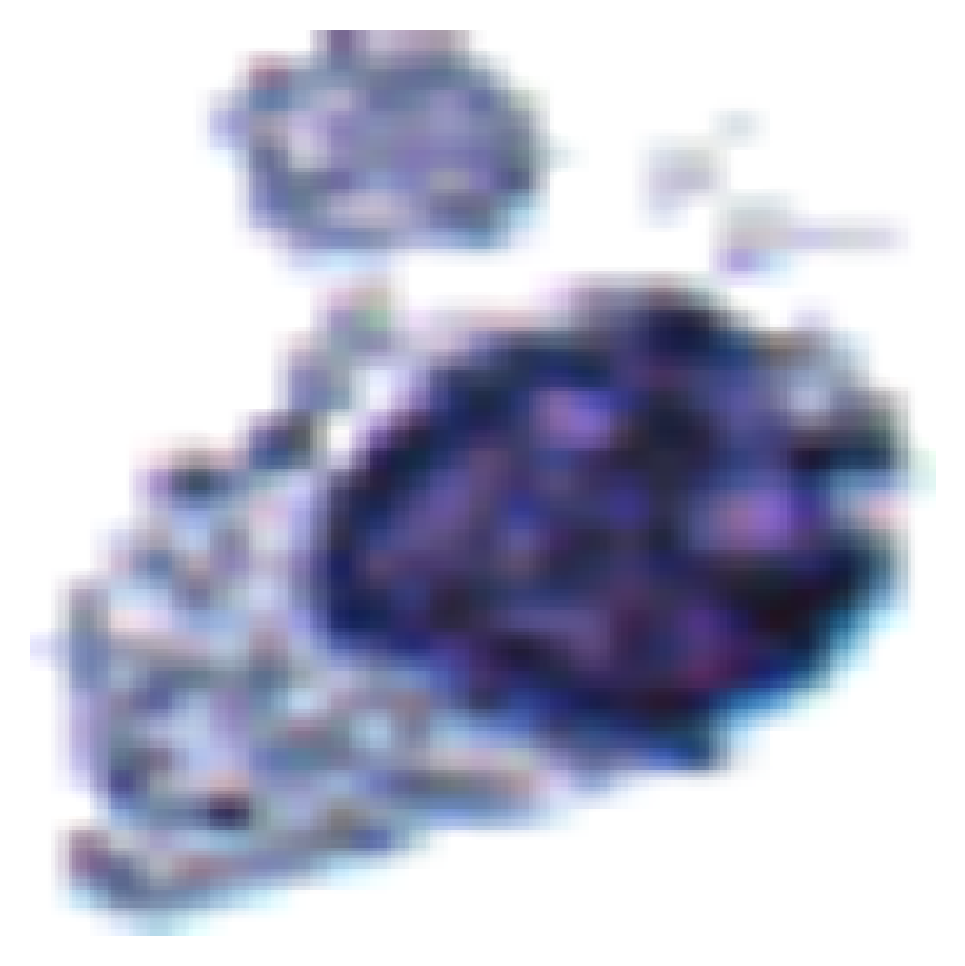

In [49]:
plt.imshow(img)
plt.axis("off")

# Convert to gray & colors, plot

In [50]:
img_gray=rgb2gray(img)

(-0.5, 255.5, 255.5, -0.5)

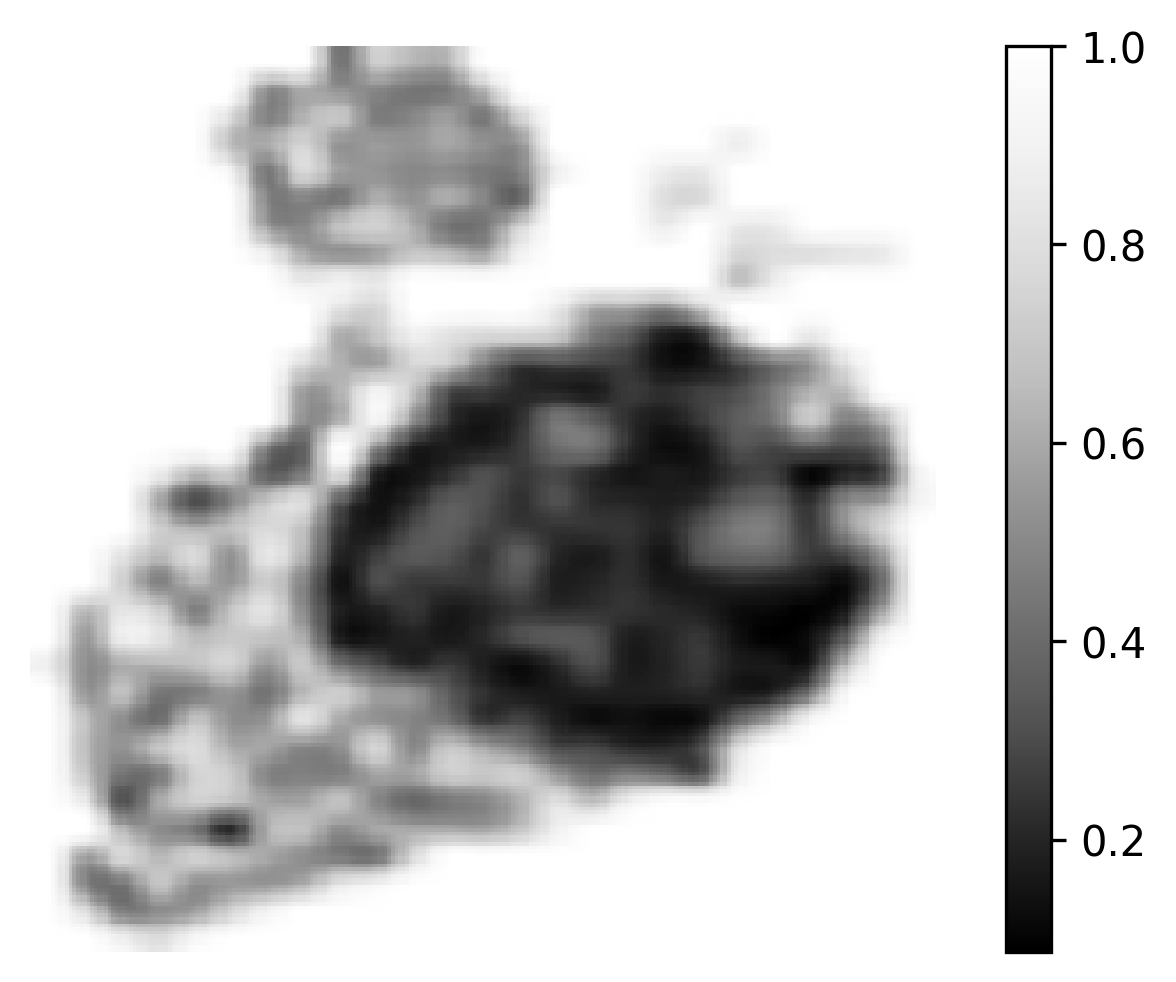

In [51]:
plt.imshow(img_gray,cmap="Greys_r")
plt.colorbar()
plt.axis("off")

(-0.5, 255.5, 255.5, -0.5)

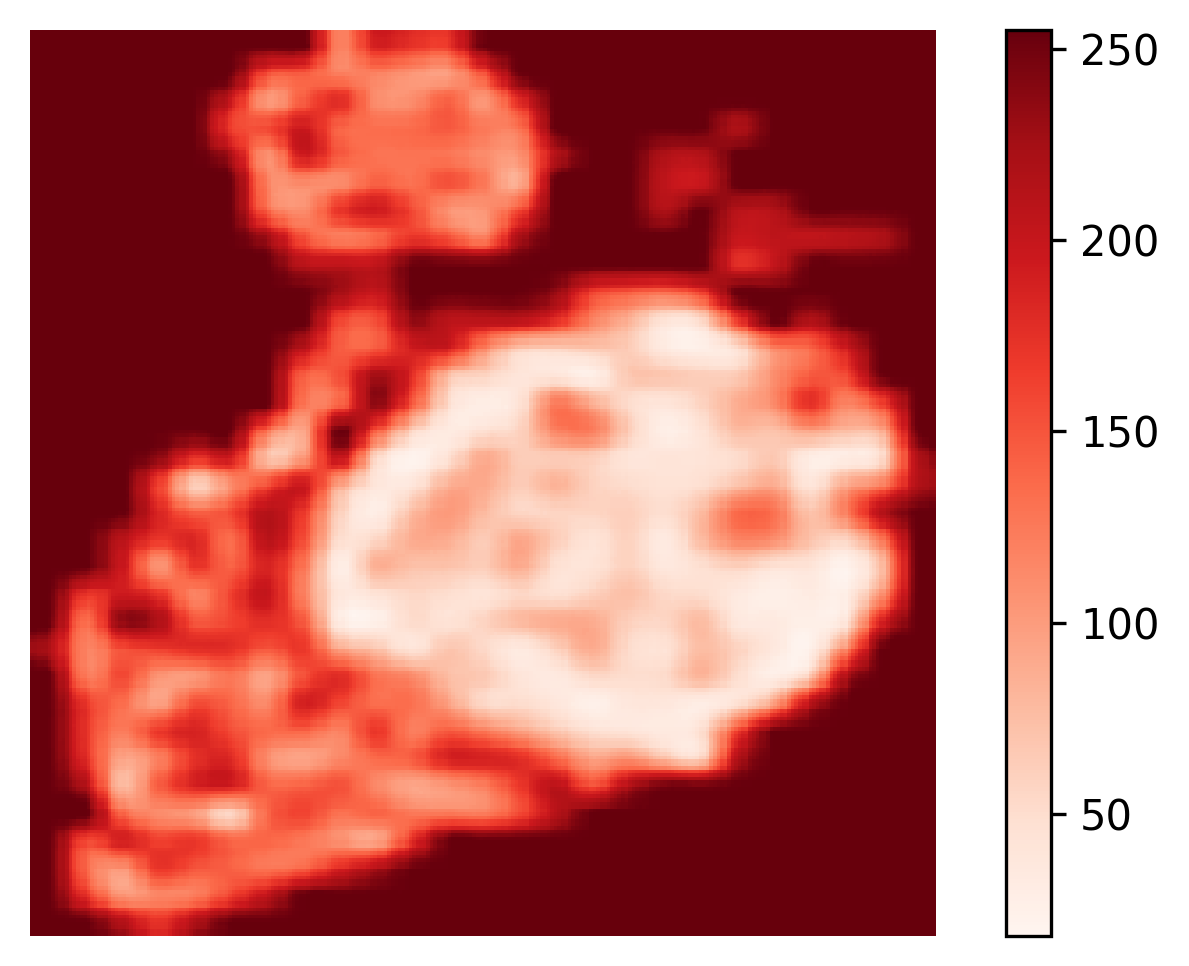

In [52]:
plt.imshow(img[...,0],cmap="Reds")
plt.colorbar()
plt.axis("off")

(-0.5, 255.5, 255.5, -0.5)

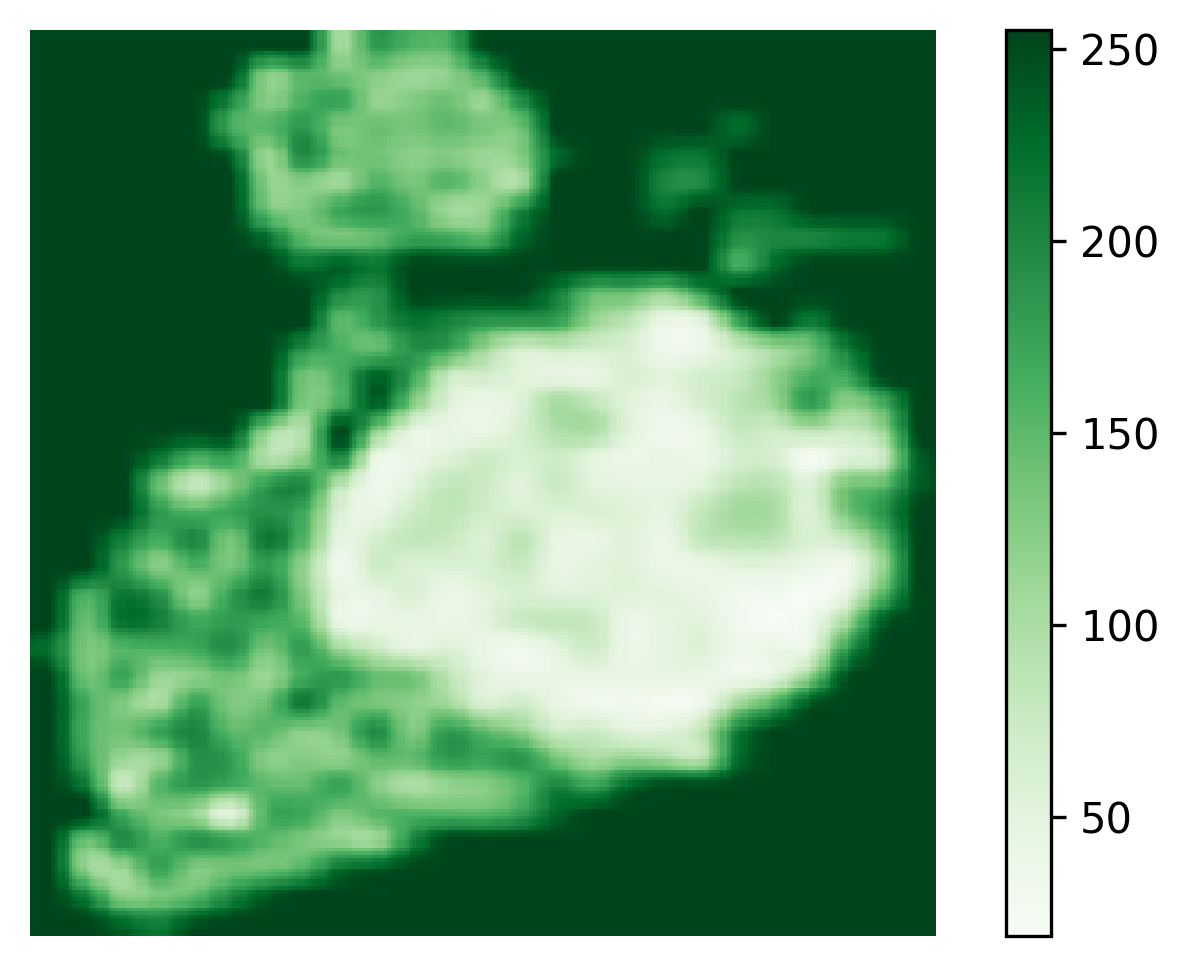

In [53]:
plt.imshow(img[...,1],cmap="Greens")
plt.colorbar()
plt.axis("off")

(-0.5, 255.5, 255.5, -0.5)

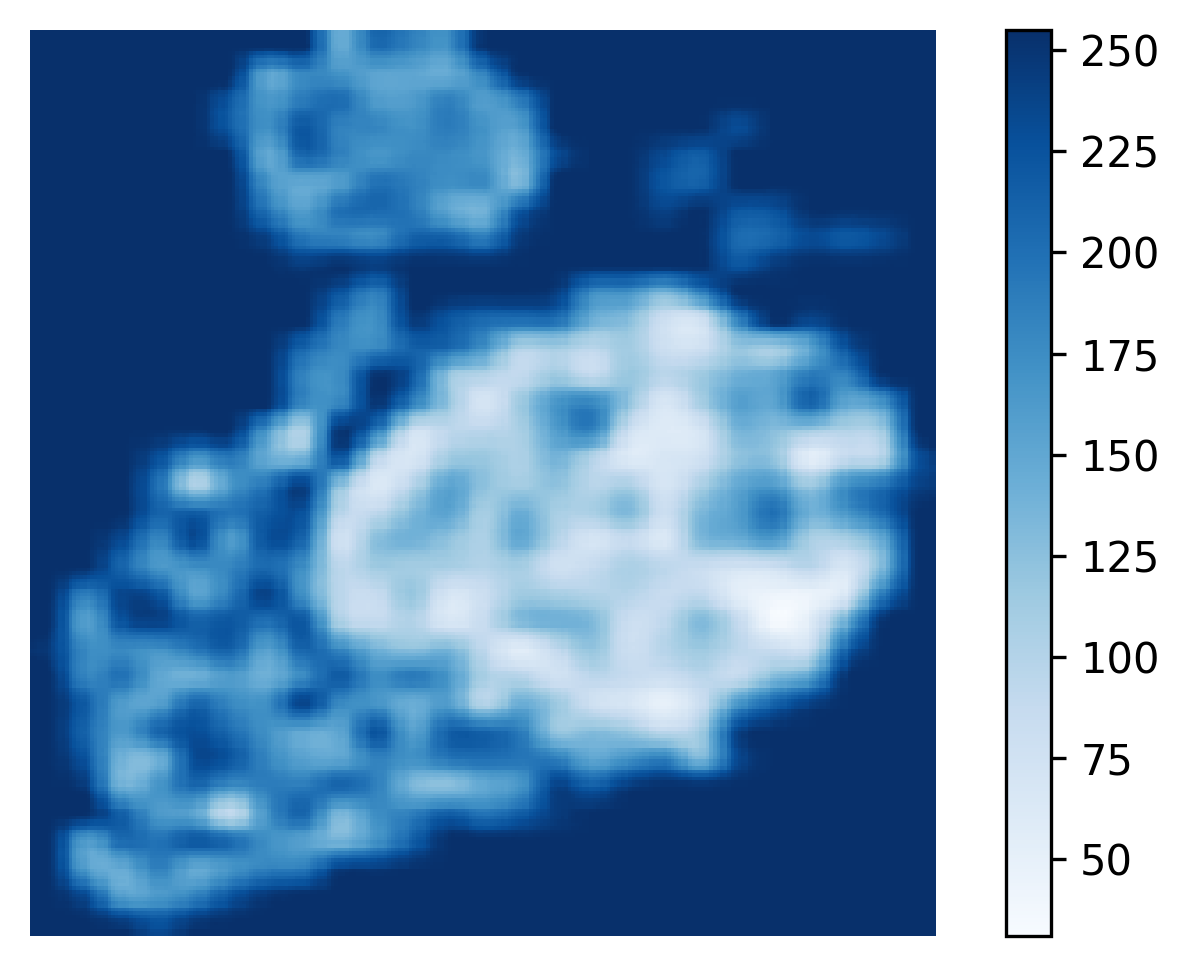

In [54]:
plt.imshow(img[...,2],cmap="Blues")
plt.colorbar()
plt.axis("off")

# Visual display of numerical values in image  (matrix)

In [55]:
img_gray_small=cv2.resize(img_gray,None,fx=1/8,fy=1/8)


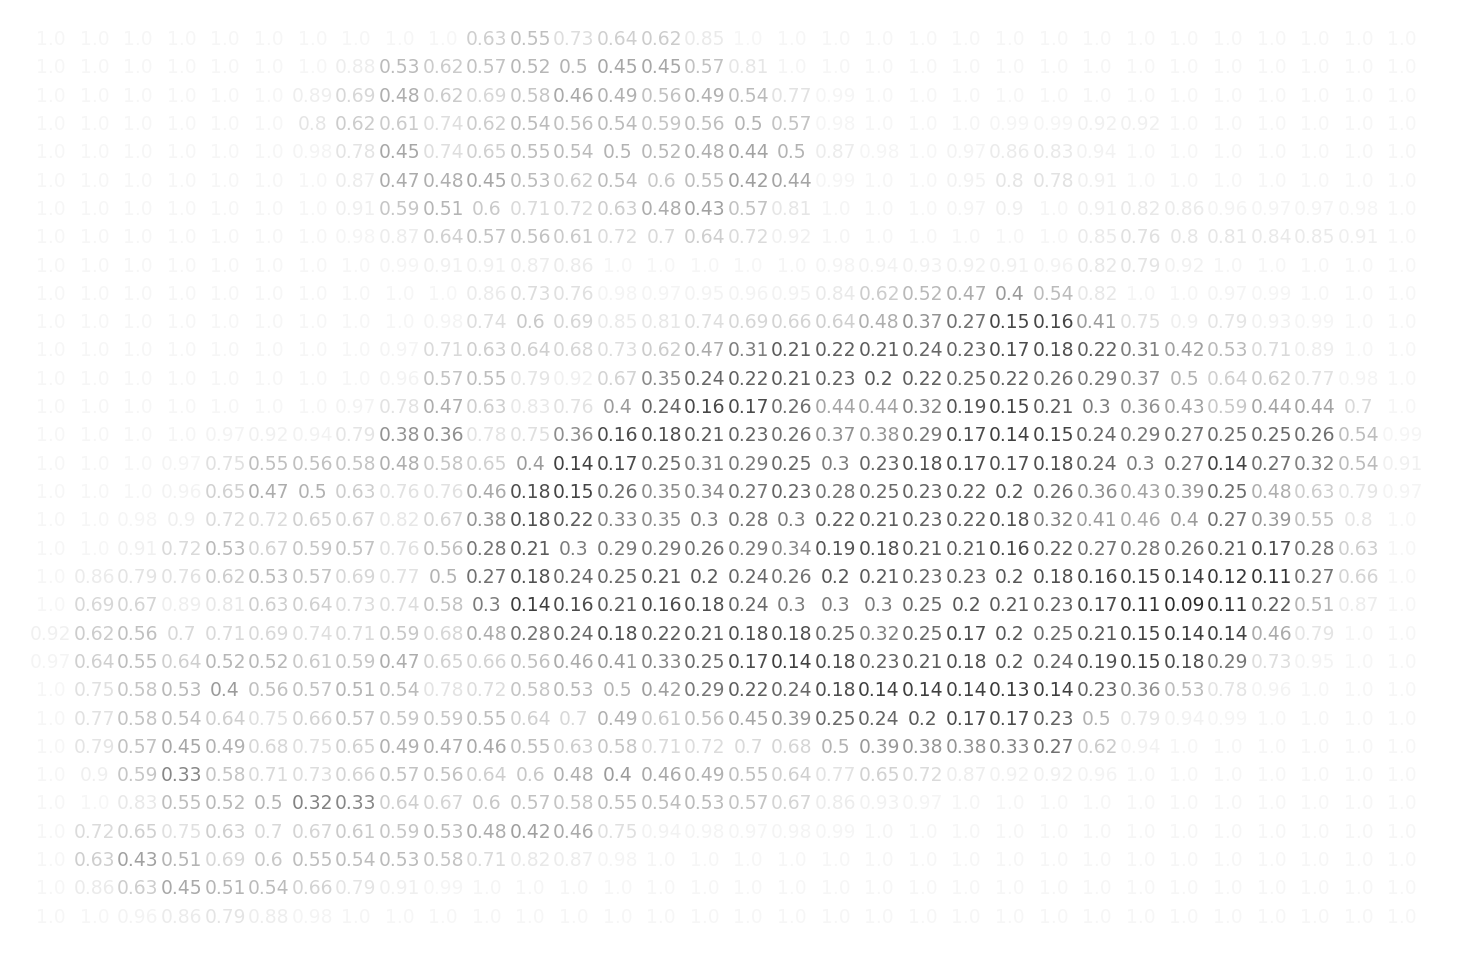

In [56]:
for i in range(img_gray_small.shape[0]):
    for j in range(img_gray_small.shape[0]):
        text = plt.text(j/img_gray_small.shape[0], i/img_gray_small.shape[0], str(round(img_gray_small[i, j],2)),
                       ha="center", va="center", color="k", alpha=(1-img_gray_small[i, j]/1.5)**3, fontsize=4.5)#**2/2
plt.axis("off")
plt.gca().invert_yaxis()

# Thresholding to identify nucleus and cytoplasm

(-0.5, 255.5, 255.5, -0.5)

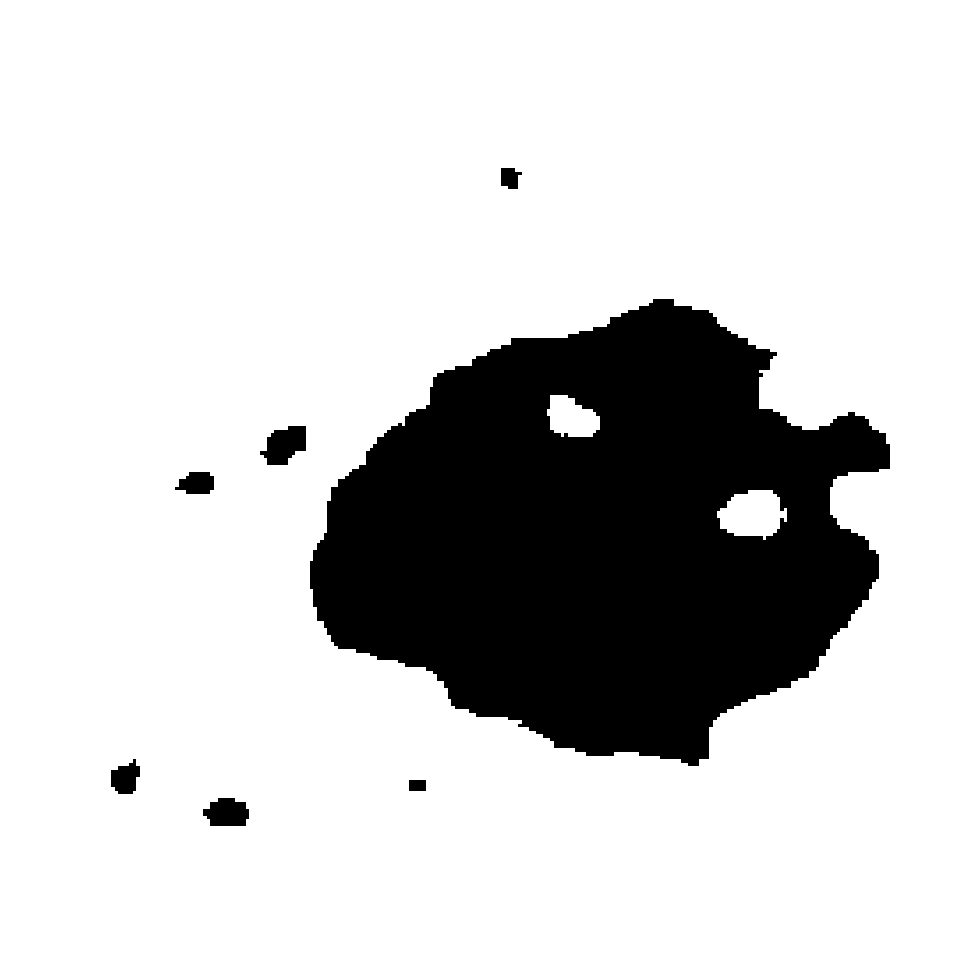

In [57]:
nucleus=img_gray<0.4
plt.imshow(nucleus,cmap="Greys")
plt.axis("off")

### Morphological operations to improve nucleus prediction

(-0.5, 255.5, 255.5, -0.5)

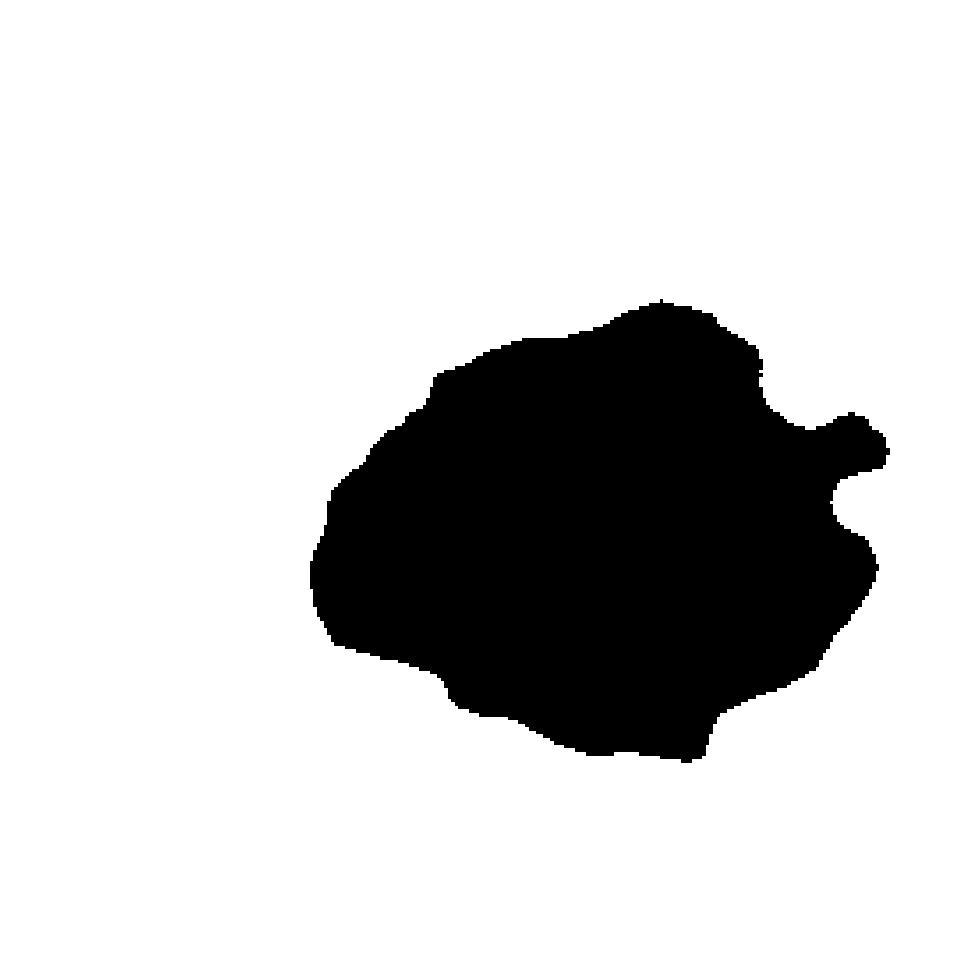

In [69]:
nucleus=img_gray<0.4
nucleus=binary_opening(nucleus,disk(5))
nucleus=binary_closing(nucleus,disk(8))
plt.imshow(nucleus,cmap="Greys")
plt.axis("off")

(-0.5, 255.5, 255.5, -0.5)

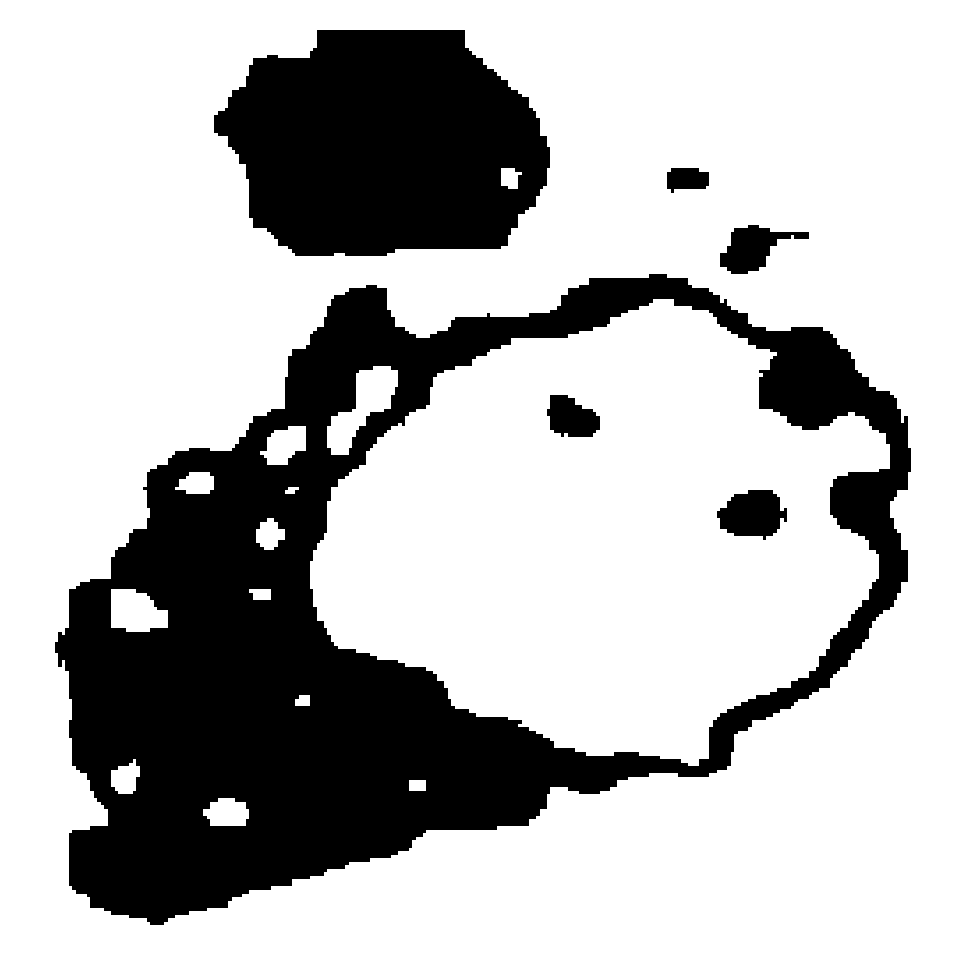

In [59]:
cytoplasm=np.logical_and(img_gray>=0.4,img_gray<=0.8)
plt.imshow(cytoplasm,cmap="Greys")
plt.axis("off")

## Calculate NC ratio

In [60]:
nc_ratio_pred=nucleus.sum()/(nucleus.sum()+cytoplasm.sum())

# Visualize true segmentation mask

In [61]:
lbl=imread("train/labels/10.png")[...,0]

(-0.5, 255.5, 255.5, -0.5)

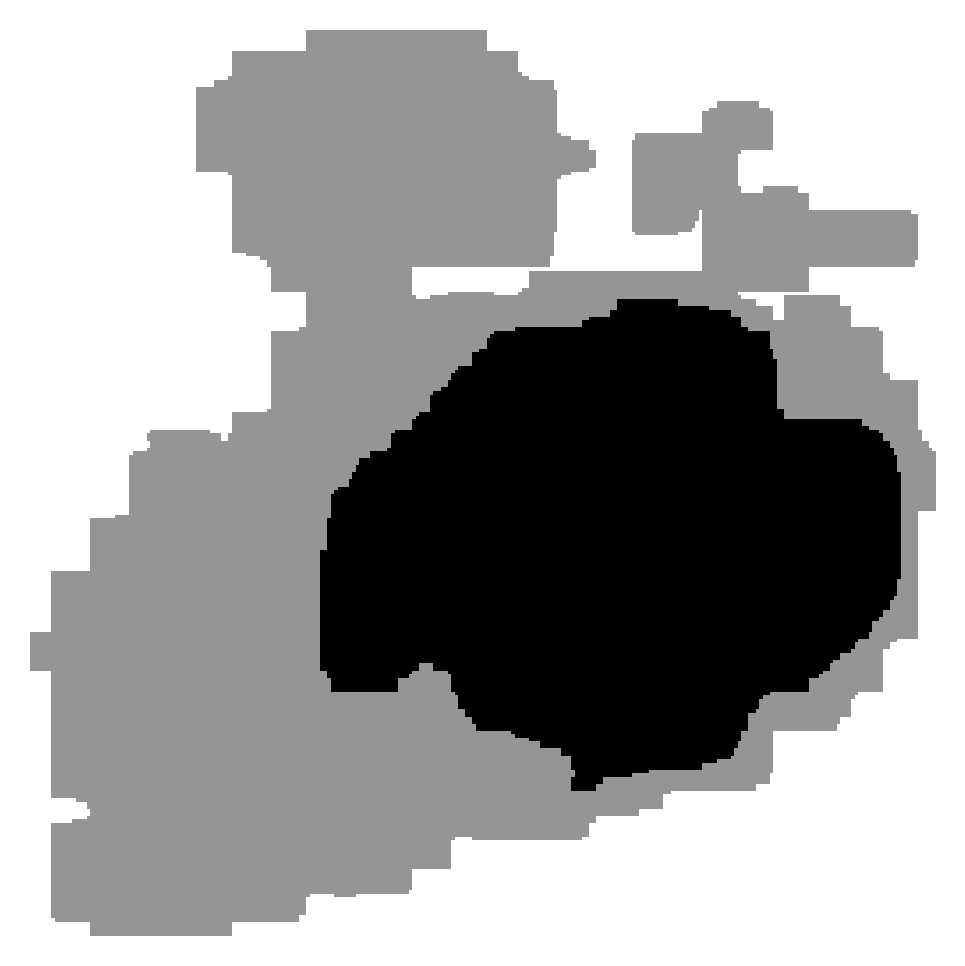

In [100]:
plt.imshow(lbl,cmap="Greys")# plt.imshow((lbl+1)%3,cmap="RdBu")
plt.axis("off")

(-0.5, 255.5, 255.5, -0.5)

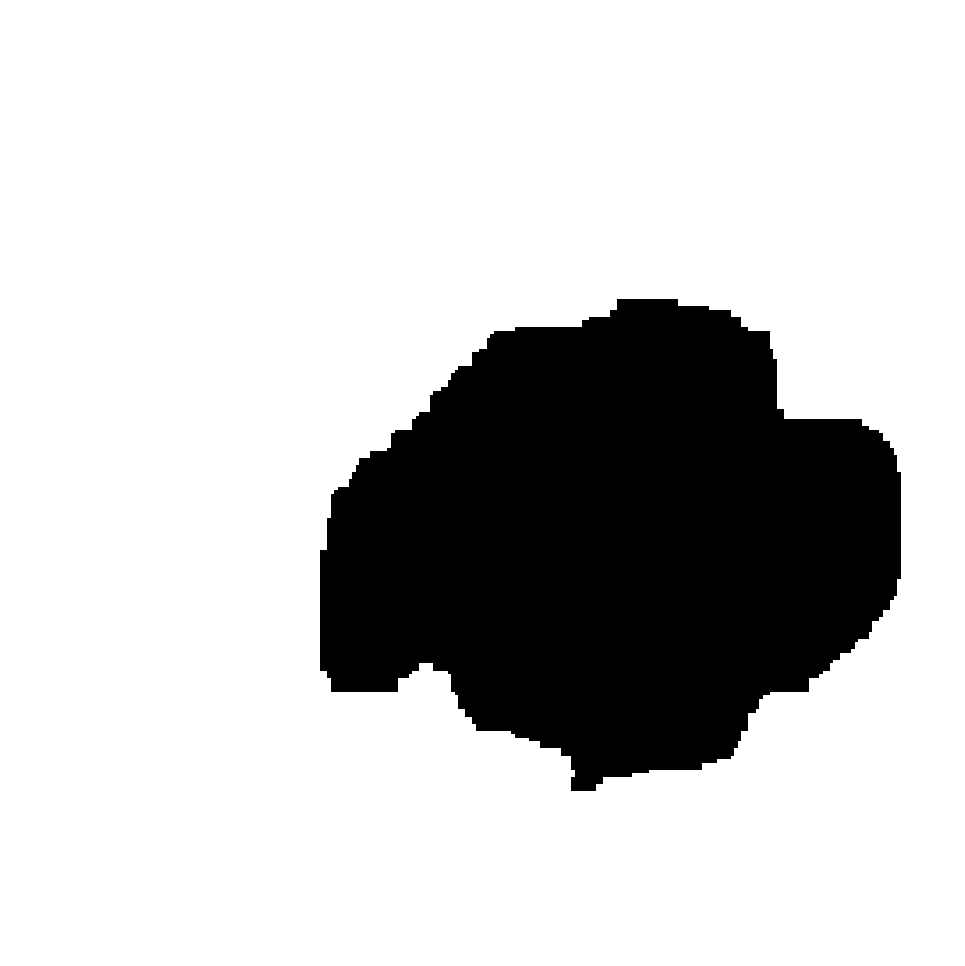

In [62]:
nucleus_true=(lbl==2)
plt.imshow(nucleus_true,cmap="Greys")
plt.axis("off")

(-0.5, 255.5, 255.5, -0.5)

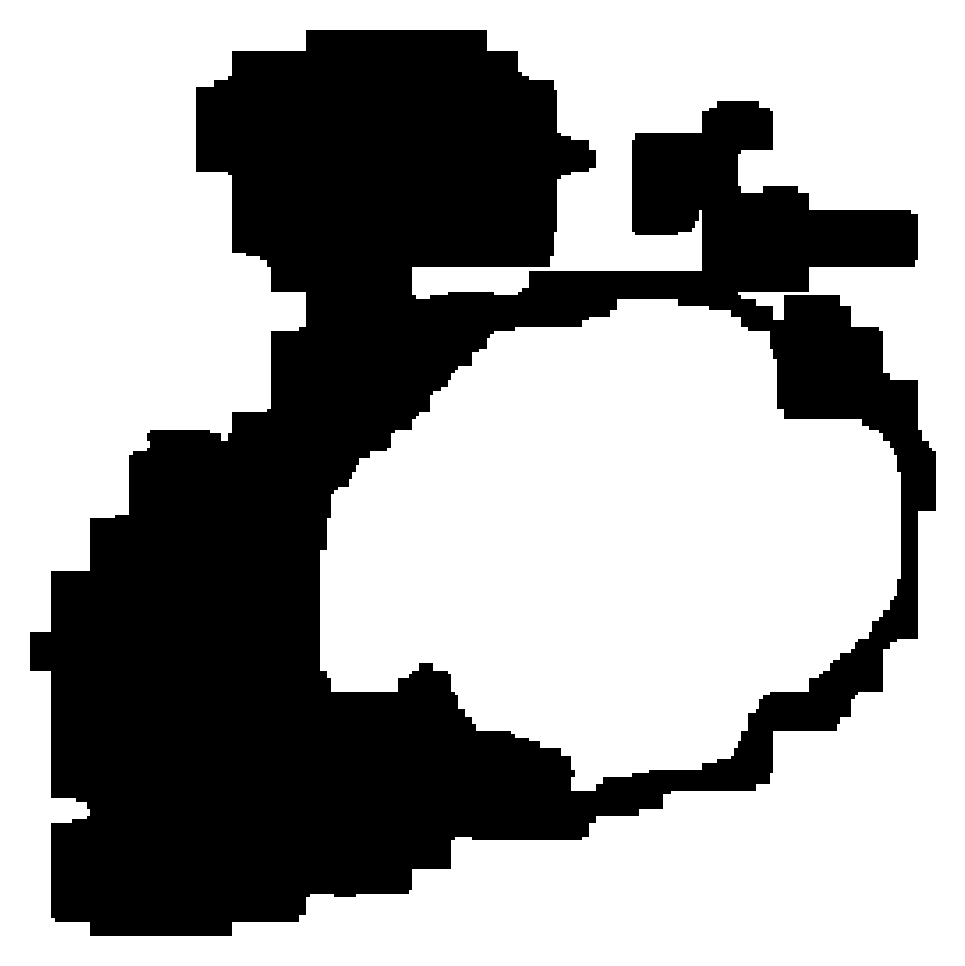

In [63]:
cytoplasm_true=(lbl==1)
plt.imshow(cytoplasm_true,cmap="Greys")
plt.axis("off")

## Calculate true NC ratio and compare

In [64]:
nc_ratio_true=nucleus_true.sum()/(nucleus_true.sum()+cytoplasm_true.sum())

In [65]:
nc_ratio_true,nc_ratio_pred

(0.3643818624523361, 0.41576448792913795)

# Extract bounding box of nucleus

In [66]:
rp=regionprops(nucleus_true.astype(int))
xmin,ymin,xmax,ymax=rp[0].bbox

(-0.5, 255.5, 255.5, -0.5)

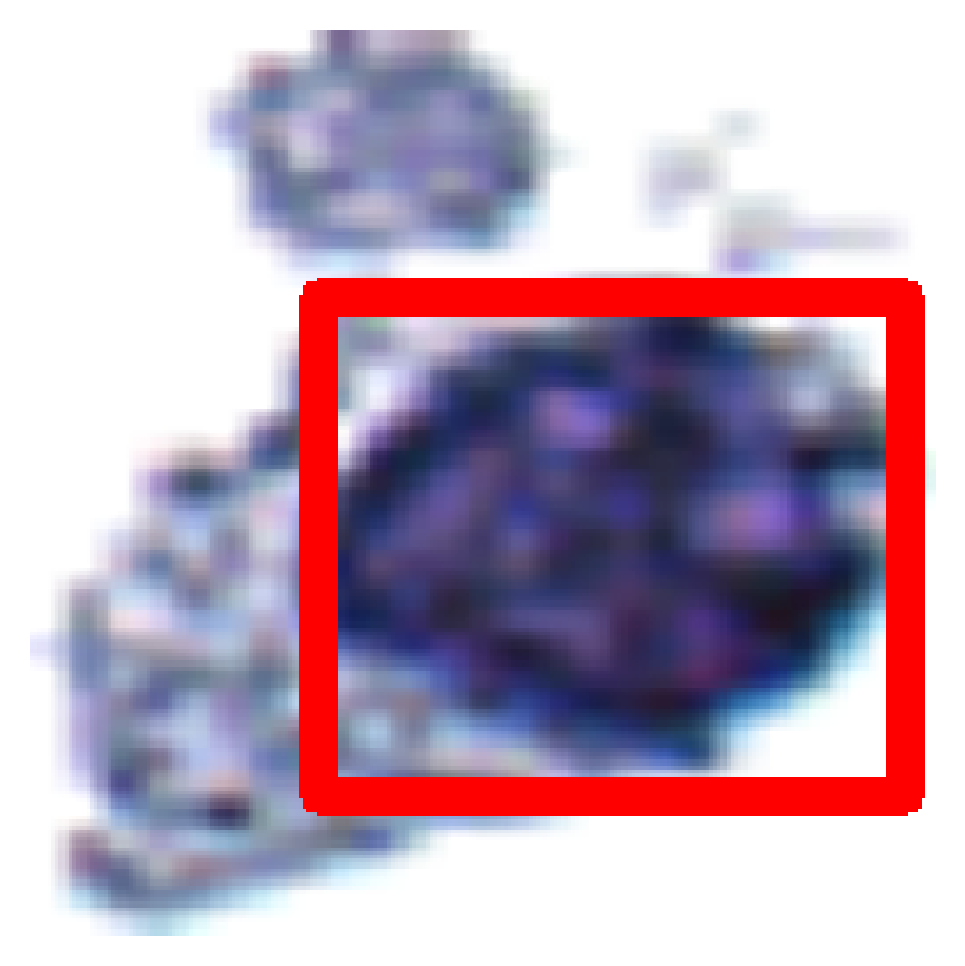

In [67]:
r,c=rectangle_perimeter((xmin,ymin),(xmax,ymax))
rec_lbl=np.zeros(lbl.shape)
rec_lbl[r,c]=1
rec_lbl=binary_dilation(rec_lbl,disk(5))
img_new=img.copy()
img_new[rec_lbl]=[255,0,0]

plt.imshow(img_new)
plt.axis("off")

# Slice image and plot

(-0.5, 163.5, 138.5, -0.5)

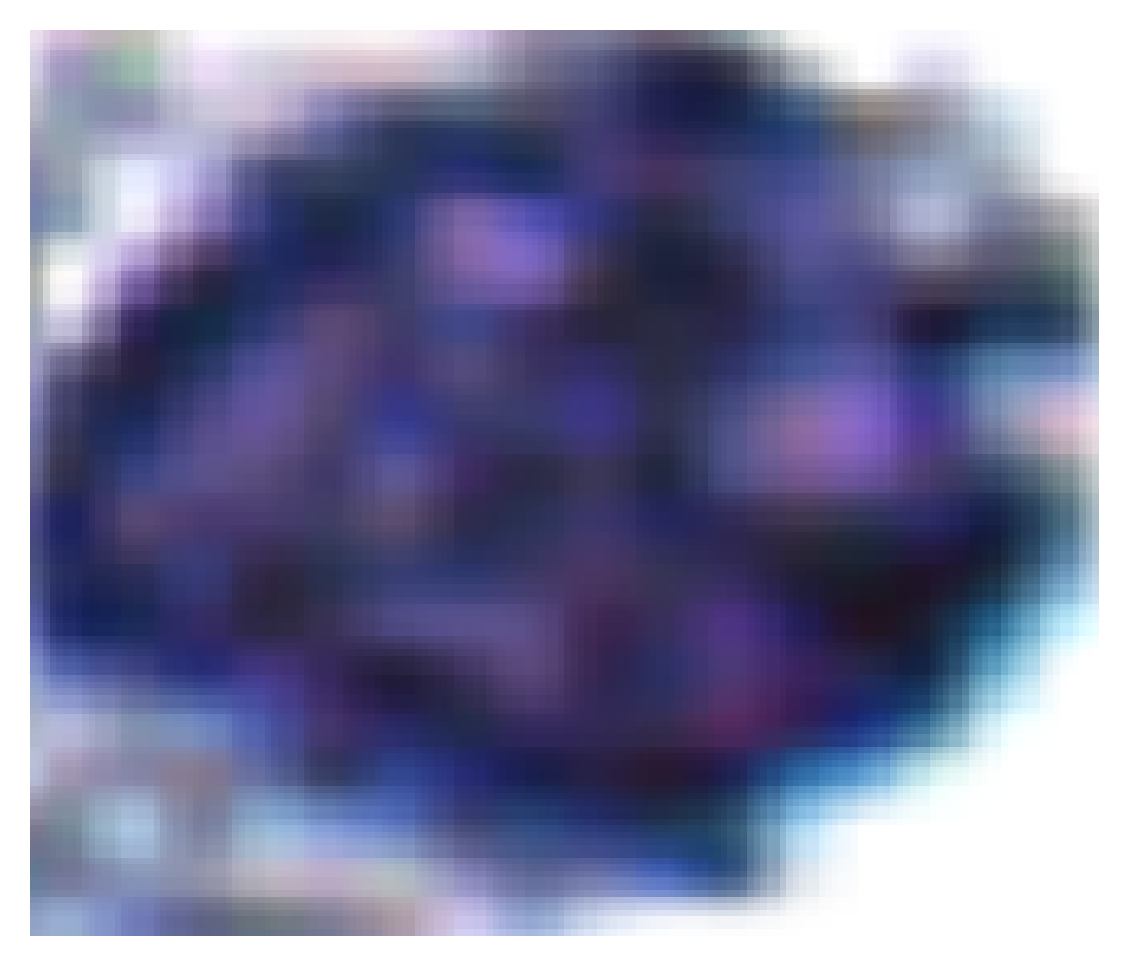

In [68]:
plt.imshow(img[xmin:xmax,ymin:ymax])
plt.axis("off")

# Features & Filters
## Run sobel filter to detect edges

(-0.5, 255.5, 255.5, -0.5)

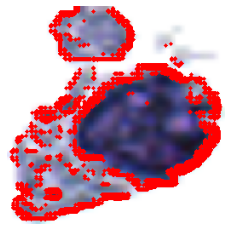

In [179]:
edges=binary_opening(sobel(img_gray)>0.03,disk(2))
img_new=img.copy()
img_new[edges]=[255,0,0]
plt.imshow(img_new)
plt.axis("off")

## Smooth sobel filter with additional morphological operations to improve edge detection

(-0.5, 255.5, 255.5, -0.5)

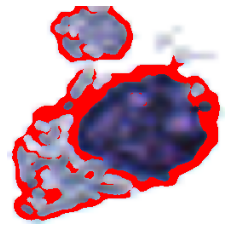

In [197]:
edges=gaussian(sobel(img_gray),sigma=2)>0.03
edges=binary_erosion(binary_opening(edges,disk(2)),disk(3))
img_new=img.copy()
img_new[edges]=[255,0,0]
plt.imshow(img_new)
plt.axis("off")

## Canny edge detection

(-0.5, 255.5, 255.5, -0.5)

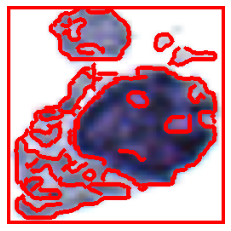

In [100]:
edges=binary_dilation(canny(img_gray, sigma=2.),disk(2))
img_new=img.copy()
img_new[edges]=[255,0,0]
plt.imshow(img_new)
plt.axis("off")


# Connected component analysis
### Identify cell

(-0.5, 255.5, 255.5, -0.5)

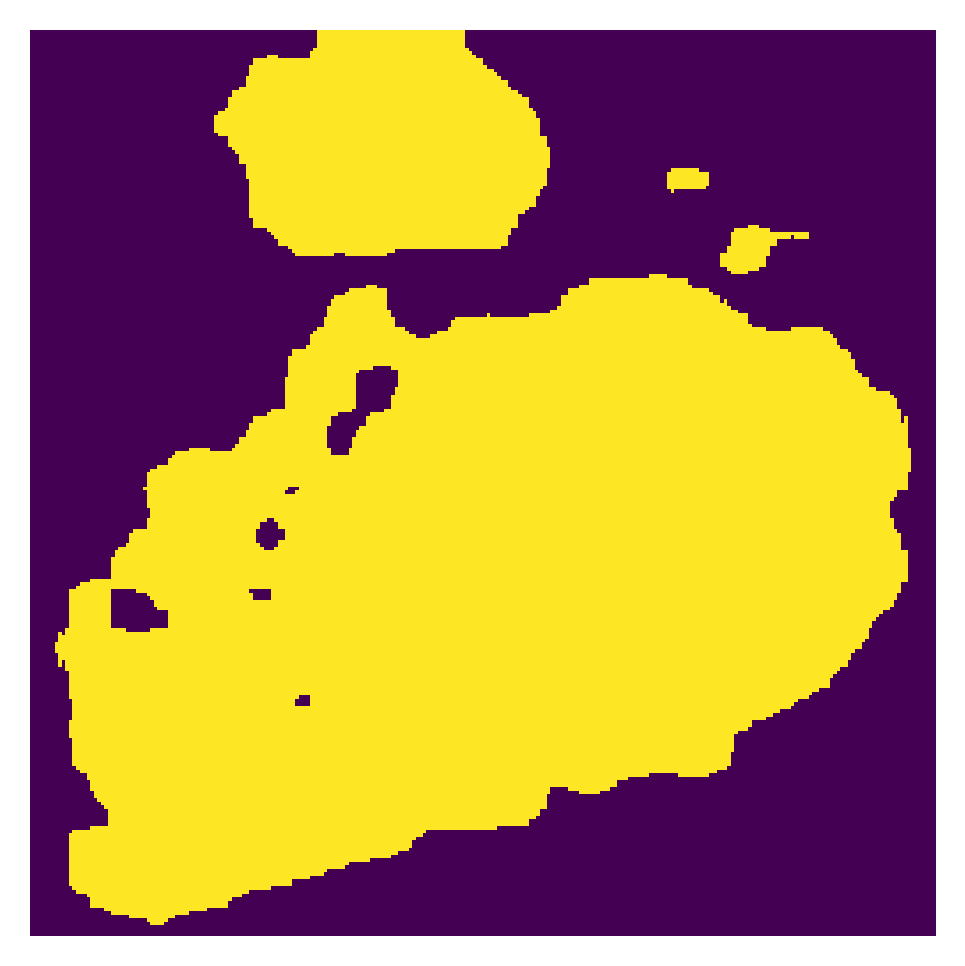

In [43]:
cell=img_gray<=0.8

plt.imshow(cell)
plt.axis("off")

### Divide into components

(-0.5, 255.5, 255.5, -0.5)

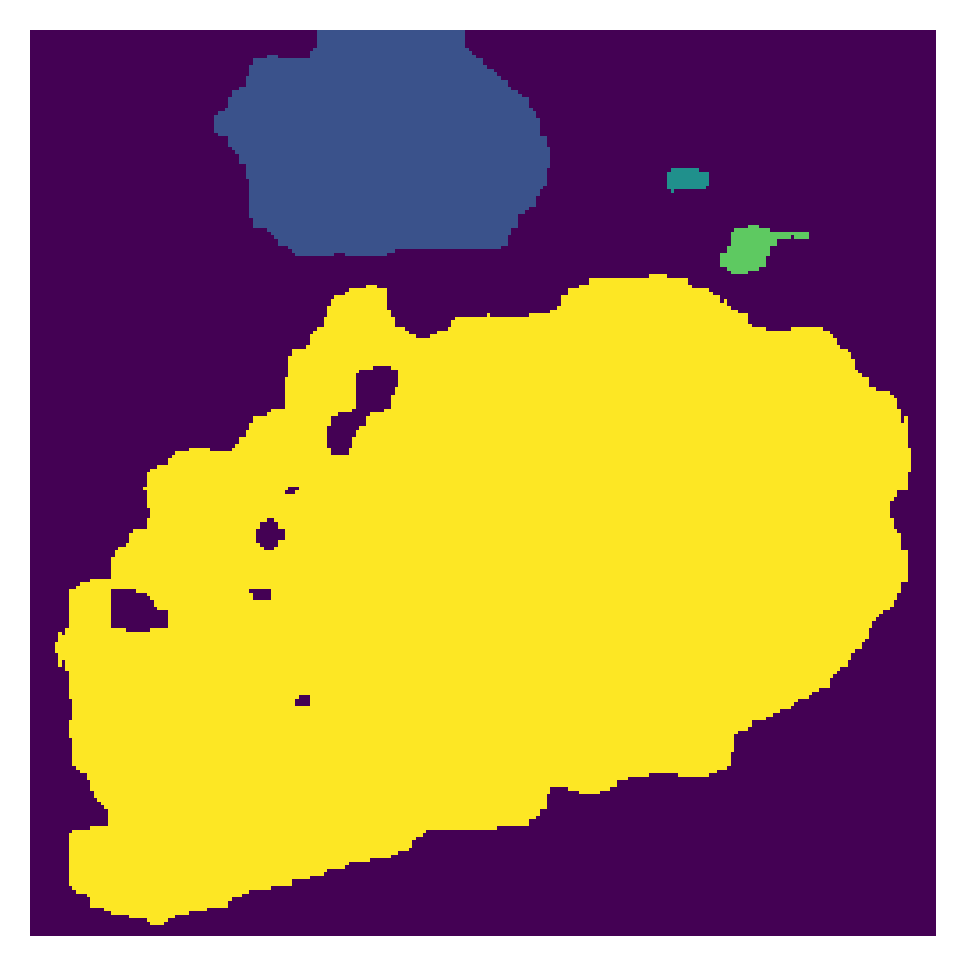

In [70]:
lbls=scilabel(cell)[0]
plt.imshow(lbls)
plt.axis("off")

## Sort components by area and take largest area component

In [71]:
rp=regionprops_table(lbls,properties=["label","area"])
rp=pd.DataFrame(rp).sort_values("area",ascending=False)
rp

,label,area
3,4,29590
0,1,4743
2,3,173
1,2,68


(-0.5, 255.5, 255.5, -0.5)

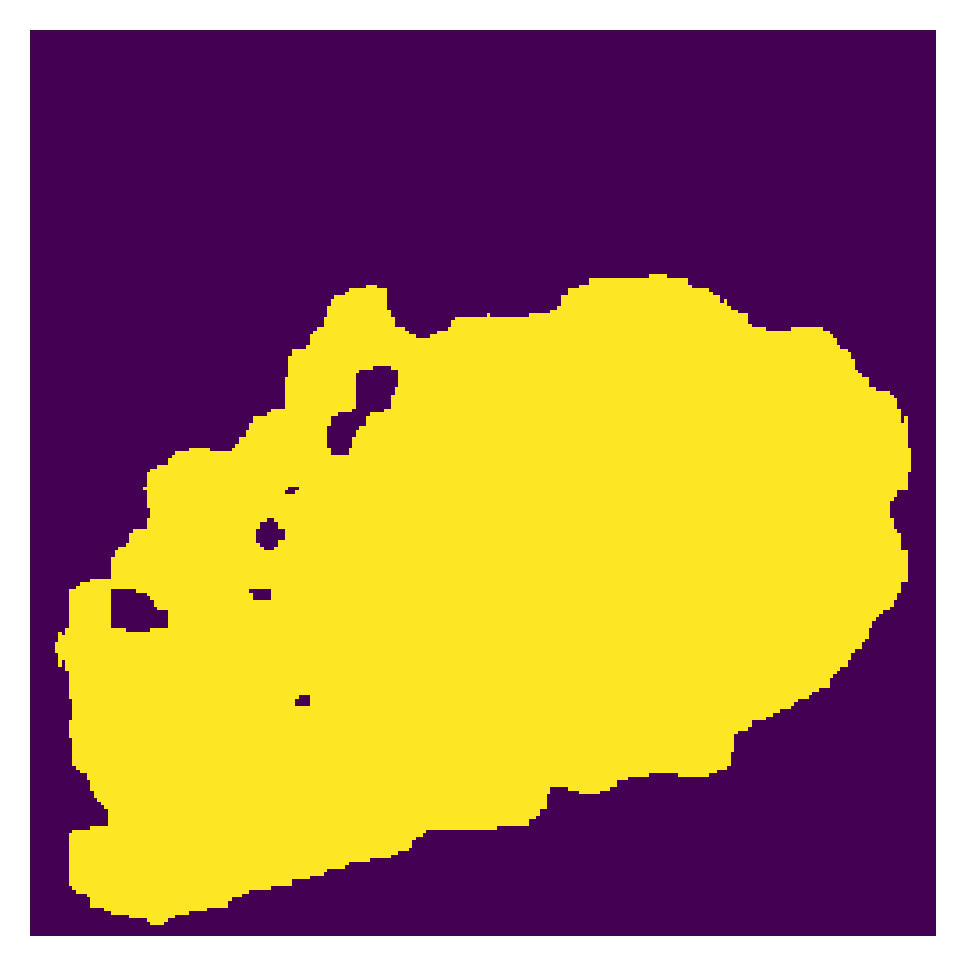

In [73]:
cell_filtered=(lbls==rp.iloc[0]['label'])
plt.imshow(cell_filtered)
plt.axis("off")

# Extract features for further analysis
## Example of a few morphological features

(-0.5, 255.5, 255.5, -0.5)

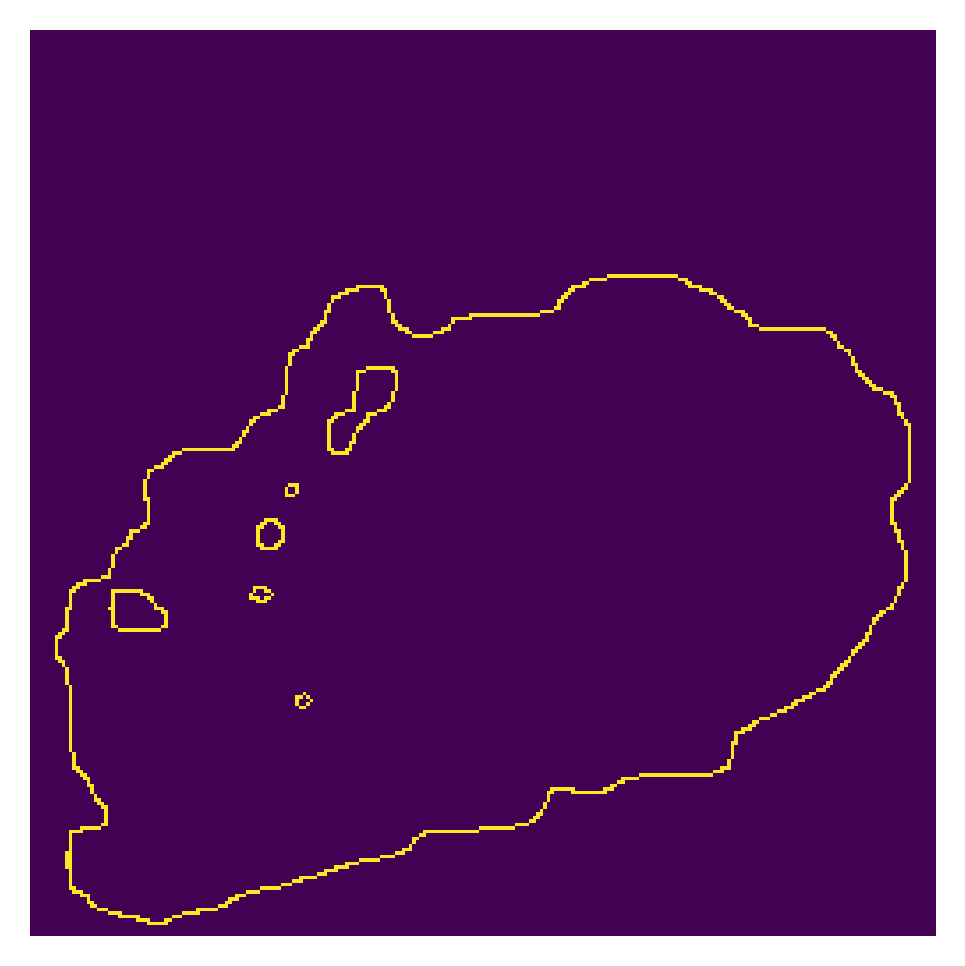

In [89]:
cell_filtered=canny(lbls==rp.iloc[0]['label'].astype(float))
plt.imshow(cell_filtered)
plt.axis("off")

In [87]:
PROPERTIES=['area', 'convex_area', 'eccentricity', 'equivalent_diameter', 'extent',
       'feret_diameter_max', 'filled_area', 'major_axis_length',
       'minor_axis_length', 'perimeter', 'solidity']

pd.DataFrame(regionprops_table(cell_filtered.astype(int),properties=PROPERTIES)).T

,0
area,29590.000000
convex_area,32450.000000
eccentricity,0.827524
equivalent_diameter,194.100897
extent,0.664526
feret_diameter_max,271.516114
filled_area,30055.000000
major_axis_length,263.841664
minor_axis_length,148.128585
perimeter,1025.009235
